# Classification of Animals in 10 classes

# 1. Importing Libraries

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
import keras.callbacks as callbacks
from keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

## 2. Loading the dataset

### Narrowing down the dataset 

Narrowing it down to 1000 images per class (10,000 images in total) for training and 400 images per class (4,000 images in total) for testing.

Quindi, prendo le prime 1000 e le butto in train, le altre 400 in test.

In [2]:
current_path = os.getcwd()
raw_data_path = os.path.join(current_path, 'raw-img')


In [3]:
# Load data
train_data = []
train_labels = []
test_data = []
test_labels = []


In [4]:
labels = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [5]:

print("Loading all animal images...")
for label in tqdm(labels):
    path = os.path.join(raw_data_path, label)
    class_num = labels.index(label)
    # the first 1000 images are for training, 400 for testing, the rest will be skipped
    for img in os.listdir(path)[:1000]:
        img_array = plt.imread(os.path.join(path, img))
        #or using numpy:
        train_data.append(img_array)
        train_labels.append(class_num)
    for img in os.listdir(path)[1000:1400]:
        img_array = plt.imread(os.path.join(path, img))
        test_data.append(img_array)
        test_labels.append(class_num)
print("\nDone!")
# X_train = np.array(train_data)
# y_train = np.array(train_labels)
# X_test = np.array(test_data)
# y_test = np.array(test_labels)

Loading all animal images...


100%|██████████| 10/10 [01:33<00:00,  9.30s/it]


Done!


In [4]:
len(train_data), len(train_labels), len(test_data), len(test_labels)

(10000, 10000, 4000, 4000)

In [6]:
#write data to "data/train" and "data/test" in a corresponding label folder ("cane", "cavallo", etc.)
# first, create the folders
train_path = os.path.join(current_path, 'data/train')
test_path = os.path.join(current_path, 'data/test')
for label in labels:
    os.makedirs(os.path.join(train_path, label), exist_ok=True)
    os.makedirs(os.path.join(test_path, label), exist_ok=True)


In [7]:
# then, write the images
print("Writing images to disk...")
for i in tqdm(range(len(train_data))):
    plt.imsave(os.path.join(train_path, labels[train_labels[i]], str(i)+'.jpg'), train_data[i])
for i in tqdm(range(len(test_data))):
    plt.imsave(os.path.join(test_path, labels[test_labels[i]], str(i)+'.jpg'), test_data[i])
print("\nDone!")

Writing images to disk...


100%|██████████| 4000/4000 [00:21<00:00, 182.83it/s]


Done!


In [4]:
img_path = os.path.join(current_path, 'raw-img')
train = tf.keras.utils.image_dataset_from_directory(
    img_path,
    image_size=(224,224),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=21
    )

val = tf.keras.utils.image_dataset_from_directory(
    img_path,
    image_size=(224,224),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=21
    )

#normalize the data
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train = train.map(process)
val = val.map(process)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


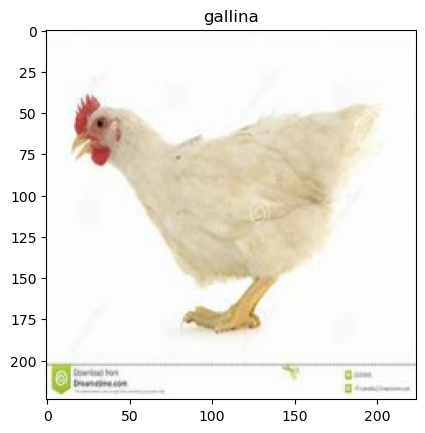

In [5]:
x = train.take(1).map(lambda x,y: (x[0],y[0])).as_numpy_iterator()
for i,j in x:
    plt.imshow(i)
    plt.title(labels[j])
    plt.show()

## 3. Data Preprocessing

## 4. Data Augmentation

In [6]:
datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5]
)

## 5. Building the model

## 6. Model compilation

In [25]:
# Callbacks
# 1. ModelCheckpoint
# 2. EarlyStopping
# 3. ReduceLROnPlateau
# 4. TensorBoard

callbacks_list = [
    callbacks.ModelCheckpoint(

        # 'mango.ckpt',
        # monitor = 'accuracy',
        # save_best_only = True,
        # mode = 'auto',
        # save_freq='epoch'

        filepath=os.path.join(current_path, 'models/kuz_model.{epoch:02d}-{val_loss:.2f}.h5'),
        monitor='val_loss',
        save_best_only=True
        
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=3,
        restore_best_weights=True,
        start_from_epoch=3

        # monitor='val_loss',
        # patience=5
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    # callbacks.TensorBoard(
    #     log_dir='logs/vgg16_model',
    #     histogram_freq=1,
    #     write_graph=True,
    #     write_grads=True,
    #     batch_size=32,
    #     write_images=True
    # )
]

callbacks_list2 = [
    callbacks.ModelCheckpoint(
        filepath=os.path.join(current_path, 'models/kuz2_model.{epoch:02d}-{val_loss:.2f}.h5'),
        monitor='val_loss',
        save_best_only=True
        
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=3,
        restore_best_weights=True,
        start_from_epoch=3
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    )
]

TypeError: EarlyStopping.__init__() got an unexpected keyword argument 'start_from_epoch'

In [16]:
kuz_model = Sequential(
    [
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ]
)

kuz_model.summary()

kuz_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    # loss=categorical_crossentropy,
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 128)     

In [21]:
kuz_model2 = Sequential(
    [
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Flatten(),
        Dense(2048, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ]
)

kuz_model2.summary()

kuz_model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    # loss=categorical_crossentropy,
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                 

In [26]:
history1 = kuz_model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=callbacks_list
)

Epoch 1/10


655/655 [==============================] - 865s 1s/step - loss: 0.7890 - accuracy: 0.7421 - val_loss: 1.0387 - val_accuracy: 0.6441 - lr: 1.0000e-04
Epoch 2/10
655/655 [==============================] - 812s 1s/step - loss: 0.5933 - accuracy: 0.8096 - val_loss: 1.0758 - val_accuracy: 0.6369 - lr: 1.0000e-04
Epoch 3/10
655/655 [==============================] - 819s 1s/step - loss: 0.4174 - accuracy: 0.8696 - val_loss: 1.0904 - val_accuracy: 0.6518 - lr: 1.0000e-04
Epoch 4/10
655/655 [==============================] - 837s 1s/step - loss: 0.2771 - accuracy: 0.9177 - val_loss: 1.1463 - val_accuracy: 0.6560 - lr: 1.0000e-04
Epoch 5/10
655/655 [==============================] - 834s 1s/step - loss: 0.1707 - accuracy: 0.9540 - val_loss: 1.2591 - val_accuracy: 0.6497 - lr: 1.0000e-04
Epoch 6/10
655/655 [==============================] - 839s 1s/step - loss: 0.1156 - accuracy: 0.9700 - val_loss: 1.3983 - val_accuracy: 0.6531 - lr: 1.0000e-04
Epoch 7/10
655/655 [==============================]

In [22]:
history2.
= kuz_model2.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=callbacks_list2
)

Epoch 1/100


655/655 [==============================] - 2249s 3s/step - loss: 1.6745 - accuracy: 0.4187 - val_loss: 1.3460 - val_accuracy: 0.5414 - lr: 1.0000e-04
Epoch 2/100
655/655 [==============================] - 2207s 3s/step - loss: 1.1322 - accuracy: 0.6181 - val_loss: 1.1278 - val_accuracy: 0.6117 - lr: 1.0000e-04
Epoch 3/100
655/655 [==============================] - 2198s 3s/step - loss: 0.7850 - accuracy: 0.7377 - val_loss: 1.0355 - val_accuracy: 0.6586 - lr: 1.0000e-04
Epoch 4/100
655/655 [==============================] - 2163s 3s/step - loss: 0.4155 - accuracy: 0.8661 - val_loss: 1.1929 - val_accuracy: 0.6690 - lr: 1.0000e-04
Epoch 5/100
655/655 [==============================] - 2161s 3s/step - loss: 0.1654 - accuracy: 0.9484 - val_loss: 1.5536 - val_accuracy: 0.6520 - lr: 1.0000e-04
Epoch 6/100
655/655 [==============================] - 2149s 3s/step - loss: 0.0846 - accuracy: 0.9748 - val_loss: 1.6952 - val_accuracy: 0.6575 - lr: 1.0000e-04
Epoch 7/100
655/655 [===================

## 7. Model Training

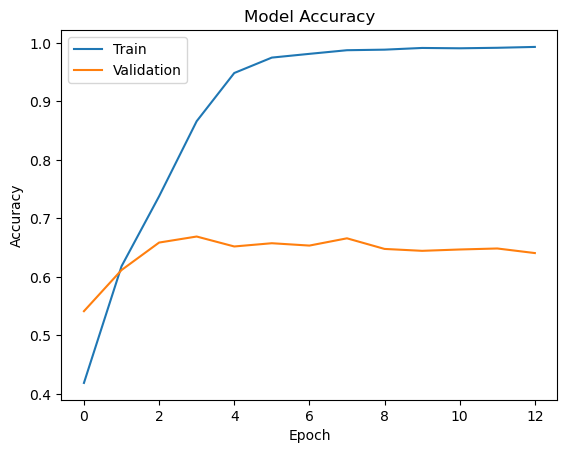

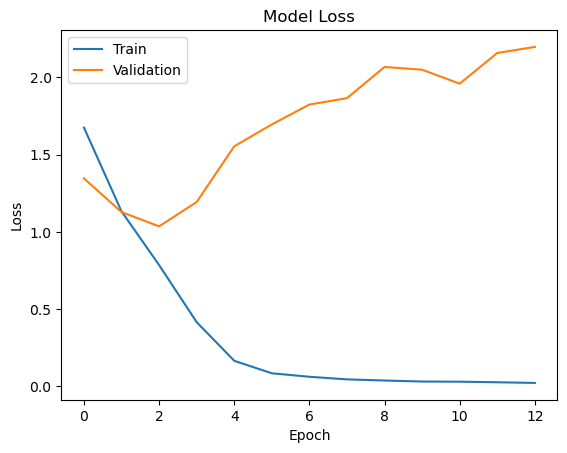

In [24]:
#plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# #save the model
# kuz_model.save('models/kuz_model.h5')
# kuz_model2.save('models/kuz2_model.h5')


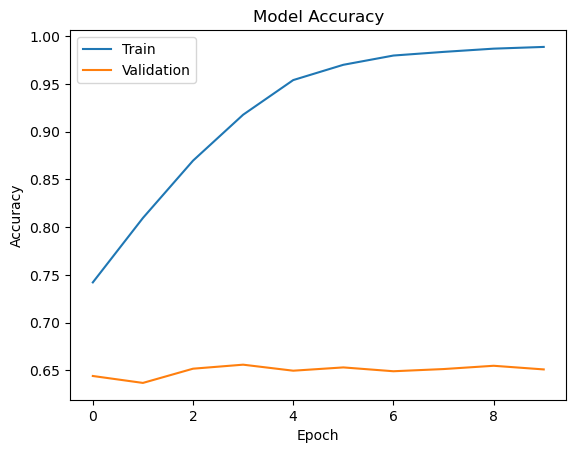

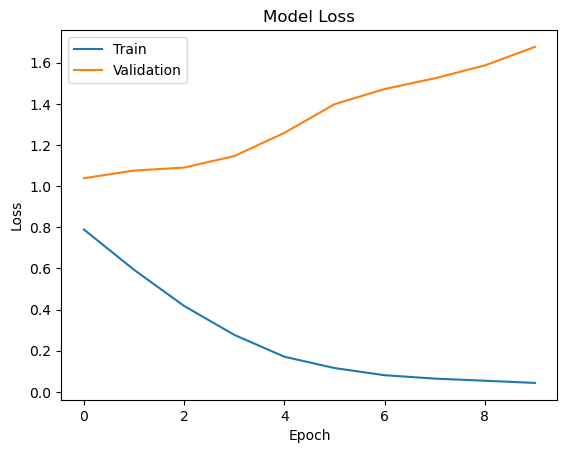

In [27]:

#plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# #save the model
# kuz_model.save('models/kuz_model.h5')
# kuz_model2.save('models/kuz2_model.h5')


## 8. Model Evaluation

## 9. Model Prediction

## 10. Saving the model

## 11. Loading the model

# The end